In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib

In [2]:
# Load the training validation and test data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars_train = data['cars_train']
notcars_train = data['notcars_train']
cars_val = data['cars_val']
notcars_val = data['notcars_val']
cars_test = data['cars_test']
notcars_test = data['notcars_test']

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [4]:
def get_features(train,validation,test):
    train_feat =   extract_features(train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    val_feat =   extract_features(validation, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    test_feat =   extract_features(test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    return train_feat,val_feat,test_feat

In [5]:
# HOG features are slow to compute
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# now get the features
t=time.time()
cars_train_feat,cars_val_feat,cars_test_feat = get_features(cars_train,cars_val,cars_test)
notcars_train_feat,notcars_val_feat,notcars_test_feat = get_features(notcars_train,notcars_val,notcars_test)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((cars_train_feat,cars_val_feat,cars_test_feat,notcars_train_feat,notcars_val_feat,notcars_test_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

51.23 Seconds to extract HOG features...


In [6]:
cars_ntrain=len(cars_train_feat)
cars_nval=len(cars_val_feat)
cars_ntest=len(cars_test_feat)
ncars_ntrain=len(notcars_train_feat)
ncars_nval=len(notcars_val_feat)
ncars_ntest=len(notcars_test_feat)

i1 = cars_ntrain
i2 = i1 + cars_nval
i3 = i2 + cars_ntest
i4 = i3 + ncars_ntrain
i5 = i4 + ncars_nval

cars_train_feat,cars_val_feat,cars_test_feat = scaled_X[:i1],scaled_X[i1:i2],scaled_X[i2:i3]
notcars_train_feat,notcars_val_feat,notcars_test_feat = scaled_X[i3:i4],scaled_X[i4:i5],scaled_X[i5:]

y_train = np.hstack((np.ones(cars_ntrain), np.zeros(ncars_ntrain)))
y_val = np.hstack((np.ones(cars_nval), np.zeros(ncars_nval)))
y_test = np.hstack((np.ones(cars_ntest), np.zeros(ncars_ntest)))

X_train = np.vstack((scaled_X[:i1],scaled_X[i3:i4]))
X_val = np.vstack((scaled_X[i1:i2],scaled_X[i4:i5]))
X_test = np.vstack((scaled_X[i2:i3],scaled_X[i5:]))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

In [7]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
11.34 Seconds to train SVC...
Validation Accuracy of SVC =  0.964
Test Accuracy of SVC =  0.9729
My SVC predicts:  [ 1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.
  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  0.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.
  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  1.
  0.  0.  1.  1.  1.  0.  0.  1.  1.  1.]
For these 100 labels:  [ 1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.
  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.
  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  1.


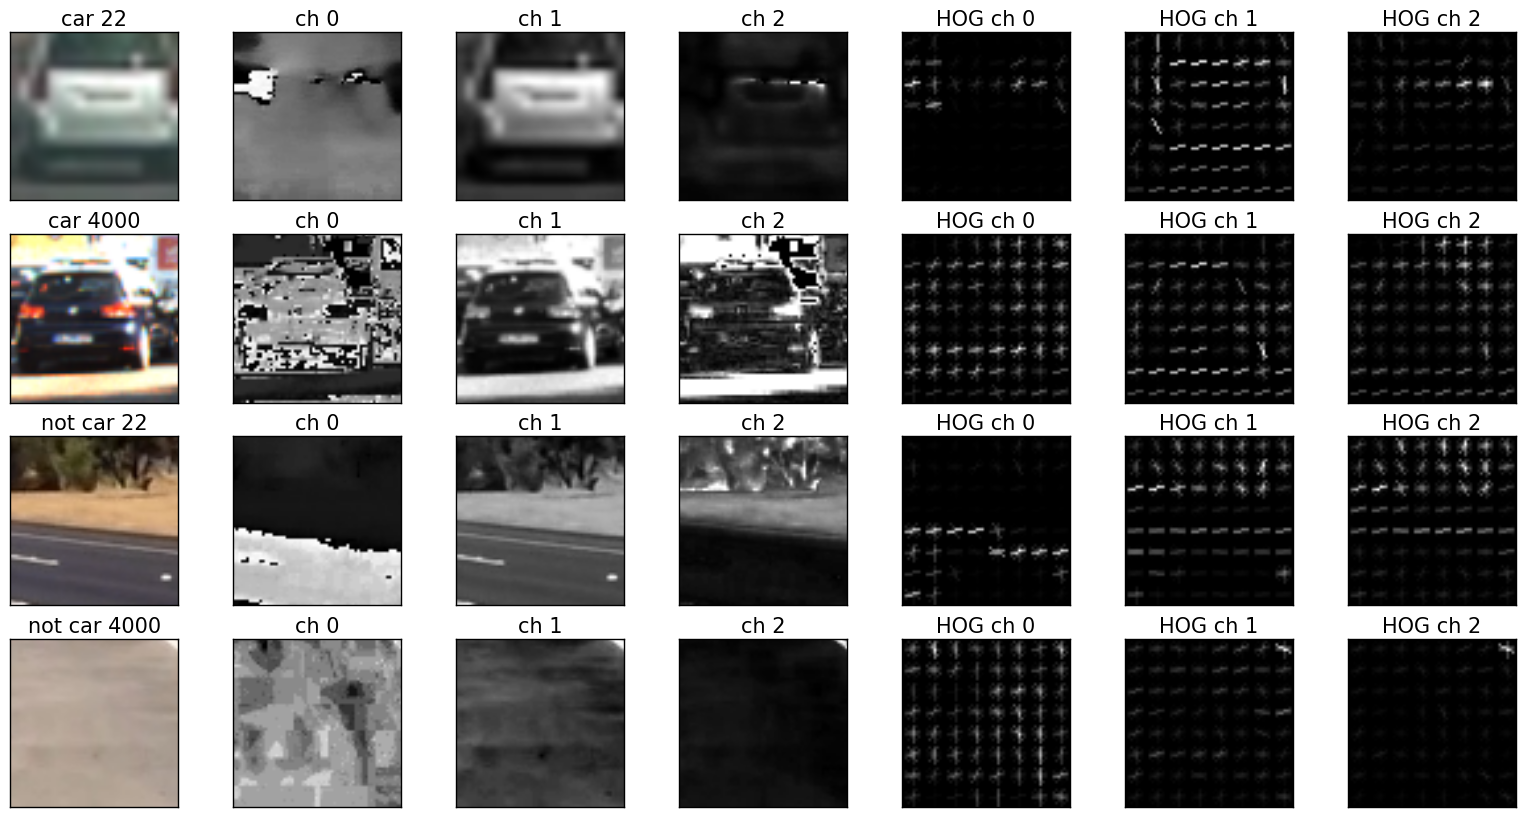

In [8]:
font_size=15
f, axarr = plt.subplots(4, 7,figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace = cv2.COLOR_RGB2HLS
#colorspace=cv2.COLOR_RGB2HSV
#colorspace=cv2.COLOR_RGB2YCrCb

i1,i2=22,4000

for ind,j in enumerate([i1,i2]):
    image = plt.imread(cars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])    
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
        
for indn,j in enumerate([i1,i2]):
    ind=indn+2
    image = plt.imread(notcars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "not car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])        
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
              
plt.show()
#plt.savefig('./images/HOG_features_HLS.png')
#plt.savefig('./images/HOG_features_YCrCb.png')

In [12]:
# When you're happy. save the classifier and the scaler for later
joblib.dump(svc, 'svc.p') ;
joblib.dump(X_scaler, 'X_scaler.p') ;